In [ ]:
# TO DO:
# General: troubleshoot step, check jump, parameterise foot, place final mass/length/inertia terms in

In [1]:
# DERIVE THE EOMs SYMBOLICALLY -------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np
import multiprocessing as mp #multiprocessing, just for the simplification steps
import time # for benchmarking different models

sym.init_printing()
from IPython.display import display, HTML
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 32em; }</style>"))

# define non--program-critical functions
def log_time(t_start=None, msg=""):
    t_end = time.perf_counter()
    if t_start == None: print("Timer initialized")
    else: print(msg + f": {t_end - t_start:.6f} sec")
    return t_end

def mp_trigsimp(m):
    mp_data = [(m[r,c]) for r in range(m.rows) for c in range(m.cols)]
    if __name__ == '__main__':
        p = mp.Pool()
        results = p.map(sym.trigsimp, mp_data)
        p.close()
        p.join()
    return sym.Matrix(results).reshape(m.rows,m.cols)

# ------------------------------------------------------------------------------------------------------------------
# create symbolic variables

# system parameters 
g = sym.symbols('g')
m1, l1, In1, d1 = sym.symbols(['m_{1}','l_{1}','I_{1}','d_{1}'])
m2, l2, In2, d2 = sym.symbols(['m_{2}','l_{2}','I_{2}','d_{2}'])
m3, l3, In3, d3 = sym.symbols(['m_{3}','l_{3}','I_{3}','d_{3}'])
m4, l4, In4, d4 = sym.symbols(['m_{4}','l_{4}','I_{4}','d_{4}'])



# generalized coordinates
x  ,  dx,  ddx = sym.symbols([          'x',          '\dot{x}',          '\ddot{x}'])
y  ,  dy,  ddy = sym.symbols([          'y',          '\dot{y}',          '\ddot{y}'])
th1,dth1,ddth1 = sym.symbols(['\\theta_{1}','\dot{\\theta}_{1}','\ddot{\\theta}_{1}'])

sides = ['L','R']

th2 = [sym.symbols('\\theta_{2%s}'%s) for s in sides]
th3 = [sym.symbols('\\theta_{3%s}'%s) for s in sides]
th4 = [sym.symbols('\\theta_{4%s}'%s) for s in sides]

dth2 = [sym.symbols('\dot{\\theta}_{2%s}'%s) for s in sides]
dth3 = [sym.symbols('\dot{\\theta}_{3%s}'%s) for s in sides]
dth4 = [sym.symbols('\dot{\\theta}_{4%s}'%s) for s in sides]

ddth2 = [sym.symbols('\ddot{\\theta}_{2%s}'%s) for s in sides]
ddth3 = [sym.symbols('\ddot{\\theta}_{3%s}'%s) for s in sides]
ddth4 = [sym.symbols('\ddot{\\theta}_{4%s}'%s) for s in sides]

q   = sym.Matrix(  [x] +   [y] +   [th1] +   th2 +   th3 +   th4)
dq  = sym.Matrix( [dx] +  [dy] +  [dth1] +  dth2 +  dth3 +  dth4)
ddq = sym.Matrix([ddx] + [ddy] + [ddth1] + ddth2 + ddth3 + ddth4)


# ------------------------------------------------------------------------------------------------------------------
# functions, # don't ask, they work for the purposes of this program
def WeirdRot(v, th):
    # weird rotation function for working with [x; y; th] vectors
    # usage: gives R_1^0 transformation, and adds the angle of rotation to the th value
    R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                    [sym.sin(th),  sym.cos(th), 0],
                    [          0,            0, 1]])
    S = sym.Matrix([[0],[0],[th]])
    return R*v + S

def WeirdAdd(v1, v2):
    # returns the sum of two vectors of the form [x; y; th]
    # both in the same ref. frame, preserving only the first angle
    v3 = sym.Matrix([[1],[1],[0]])
    return v1 + sym.matrix_multiply_elementwise(v3, v2)

def WeirdTrans(v1, ang1, off1, ang2=0, off2=sym.Matrix([[0],[0],[0]])):
    # ^ & ^ just like me
    # transforms [x,y,th] vector to inertial frame using position offsets and
    # rotation angles as specified
    rn_m = WeirdAdd(WeirdRot(v1, ang1),off1)
    rn_0 = WeirdAdd(WeirdRot(rn_m, ang2),off2)
    return rn_0


# ------------------------------------------------------------------------------------------------------------------
# mass positions, foot positions
sym0    = sym.Matrix([[0]    ,[0]     ,[0]]) #sanity check

r1_1    = sym.Matrix([[0]    ,[ l1*d1],[0]])
r2_2    = sym.Matrix([[0]    ,[-l2*d2],[0]])
r3_3    = sym.Matrix([[0]    ,[-l3*d3],[0]])
r4_4    = sym.Matrix([[l4*d4],[0]     ,[0]])
rfoot_4 = sym.Matrix([[l4]   ,[0]     ,[0]])


process_timer = log_time()

r1_0 = WeirdTrans(r1_1, th1, sym.Matrix([[x],[y],[0]]))
r2_0 = []
r3_0 = []
r4_0 = []
rhip_0   = []
rknee_0  = []
rankle_0 = []
rfoot_0  = []

for i in range(len(sides)):
    r2_0.append(WeirdTrans(r2_2, th2[i] , sym.Matrix([[x],[y],[0]])))
    r3_0.append(WeirdTrans(r3_3, th3[i]-th2[i] , r2_2*(1-d2)/d2           , th2[i] , r2_0[i]))
    r4_0.append(WeirdTrans(r4_4, th4[i]-th3[i] , r3_3*(1-d3)/d3           , th3[i] , r3_0[i]))
    
    rhip_0.append(  WeirdTrans(sym0    , th2[i] , sym.Matrix([[x],[y],[0]]))) #sanity check
    rknee_0.append( WeirdTrans(sym0    , th3[i]-th2[i] , r2_2*(1-d2)/d2           , th2[i] , r2_0[i])) #sanity check
    rankle_0.append(WeirdTrans(sym0    , th4[i]-th3[i] , r3_3*(1-d3)/d3           , th3[i] , r3_0[i]))
    rfoot_0.append( WeirdTrans(rfoot_4 , th4[i]-th3[i] , r3_3*(1-d3)/d3           , th3[i] , r3_0[i]))
    
    r2_0[i]    = sym.trigsimp(   r2_0[i])
    r3_0[i]    = sym.trigsimp(   r3_0[i])
    r4_0[i]    = sym.trigsimp(   r4_0[i])
    
#     rhip_0[i]   = sym.trigsimp(rhip_0[i])
#     rknee_0[i]  = sym.trigsimp(rknee_0[i])
#     rankle_0[i] = sym.trigsimp(rankle_0[i])
#     rfoot_0[i]  = sym.trigsimp(rfoot_0[i])

process_timer = log_time(process_timer, "Simplified 'r's")

# mass velocities, foot velocity
dr1 = r1_0.jacobian(q)*dq
dr2 = []
dr3 = []
dr4 = []
drfoot = []

for i in range(len(sides)):
    dr2.append(      r2_0[i].jacobian(q)*dq)
    dr3.append(      r3_0[i].jacobian(q)*dq)
    dr4.append(      r4_0[i].jacobian(q)*dq)
    drfoot.append(rfoot_0[i].jacobian(q)*dq)

# ------------------------------------------------------------------------------------------------------------------
# kinetic and potential energy
def Ep(m, r):
    return sym.Matrix([m*g*r[1]])

def Ek(m, In, dr):
    InM = sym.Matrix([[m,0,0],[0,m,0],[0,0,In]])
    return 0.5*dr.T*InM*dr

V = Ep(m1,r1_0)
T = [Ek(m1,In1,dr1)]

for i in range(len(sides)):
    V += Ep(m2,r2_0[i]) + Ep(m3,r3_0[i]) + Ep(m4,r4_0[i])
    
    T.append(Ek(m2,In2,dr2[i]))
    T.append(Ek(m3,In3,dr3[i]))
    T.append(Ek(m4,In4,dr4[i]))

T = sym.Matrix(T)
# T = mp_trigsimp(T)
T = sum(T[i] for i in range(len(T)))
T = sym.Matrix([T])
# process_timer = log_time(process_timer, "Simplified T")



# ------------------------------------------------------------------------------------------------------------------
# forces & torques
tau1 = sym.symbols(['\\tau_{1%s}'%s for s in sides])
tau2 = sym.symbols(['\\tau_{2%s}'%s for s in sides])
tau3 = sym.symbols(['\\tau_{3%s}'%s for s in sides])
GRFx = sym.symbols([    'G_{x%s}'%s for s in sides])
GRFy = sym.symbols([    'G_{y%s}'%s for s in sides])


tau1_l1, tau1_l2 = [],[]
tau2_l2, tau2_l3 = [],[]
tau3_l3, tau3_l4 = [],[]
GRF_r, GRFth, GRF_l4 = [],[],[]
Qtau1, Qtau2, Qtau3, QGRFs = [],[],[],[]
Qtot = sym.Matrix([[0],[0],[0],[0],[0],[0],[0],[0],[0]])

for i in range(len(sides)):
    tau1_l1.append(sym.Matrix([[0],[0],[-tau1[i]]]))
    tau1_l2.append(sym.Matrix([[0],[0], [tau1[i]]]))

    tau2_l2.append(sym.Matrix([[0],[0],[-tau2[i]]]))
    tau2_l3.append(sym.Matrix([[0],[0], [tau2[i]]]))

    tau3_l3.append(sym.Matrix([[0],[0],[-tau3[i]]]))
    tau3_l4.append(sym.Matrix([[0],[0], [tau3[i]]]))

#     GRF_r.append(WeirdRot((1-d4)*rfoot_4, th4[i]))
#     GRFth.append(GRF_r[i][0]*GRFy[i] - GRF_r[i][1]*GRFx[i])
    GRF_l4.append(sym.Matrix([[GRFx[i]],[GRFy[i]],[0]]))
    # GRFth now fixed. (2024/10/11)
    # DO NOT APPLY GRFth. IT DOUBLES UP AND CAUSES MODEL TO STAND NOT DIRECTLY OVER FEET

    Qtau1.append(     r1_0.jacobian(q).T*tau1_l1[i] + r2_0[i].jacobian(q).T*tau1_l2[i]) # tau is actually 'u', not 'Q', but shhh
    Qtau2.append(  r2_0[i].jacobian(q).T*tau2_l2[i] + r3_0[i].jacobian(q).T*tau2_l3[i])
    Qtau3.append(  r3_0[i].jacobian(q).T*tau3_l3[i] + r4_0[i].jacobian(q).T*tau3_l4[i])
    QGRFs.append(rfoot_0[i].jacobian(q).T*GRF_l4[i])

    Qtot = Qtot + Qtau1[i] + Qtau2[i] + Qtau3[i] + QGRFs[i]

# Qtot = mp_trigsimp(Qtot)
# process_timer = log_time(process_timer, "Simplified Qtot")
# ------------------------------------------------------------------------------------------------------------------
# Mass, Gravity, Coriolis matrices, EOM
LgM = sym.hessian(T, dq)
LgM = mp_trigsimp(LgM)
process_timer = log_time(process_timer, "Simplified LgM")

LgG = V.jacobian(q)

dM = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = dM.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
# dM = mp_trigsimp(dM)
# process_timer = log_time(process_timer, "Simplified dM")
Tj = T.jacobian(q)
# Tj = mp_trigsimp(Tj)
# process_timer = log_time(process_timer, "Simplified Tj")
LgC = dM*dq - Tj.T

EOM = LgM*ddq + LgC + LgG.T - Qtot
EOM = mp_trigsimp(EOM)
process_timer = log_time(process_timer, "Simplified EOM")

Timer initialized
Simplified 'r's: 2.840024 sec
Simplified LgM: 1.489152 sec
Simplified EOM: 36.087412 sec


In [2]:
# # LAMBDIFY ------------------------------------------------------------------------------------------------------------------    
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos}


sym_list = [g,
            m1 , m2, m3, m4,
            l1 , l2, l3, l4,
            In1,In2,In3,In4,
            d1 , d2, d3, d4,
            x  ,   y,  th1] +   th2 +   th3 +   th4 +\
            [dx,  dy, dth1] +  dth2 +  dth3 +  dth4 +\
            [ddx,ddy,ddth1] + ddth2 + ddth3 + ddth4 +\
            tau1 + tau2 + tau3 +\
            GRFx + GRFy

# DOFs
DOF0 = [('x','b'),('y','b'),('th1','b')]
DOF1 = ['th2','th3','th4']

DOFs  = [(  'x','b'),
         (  'y','b'),
         ('th1','b'),
         ('th2','L'),
         ('th2','R'),
         ('th3','L'),
         ('th3','R'),
         ('th4','L'),
         ('th4','R')]
TDOFs = ['x','y']

links = ['b','l1','l2','l3']
joints = ['hip','knee','ankle']

lamb_EOM  = {}
for dof_i, dof in enumerate(DOFs):
    lamb_EOM[dof]    = sym.lambdify(sym_list, EOM[dof_i],modules = [func_map])
    
lamb_footp = {}
lamb_footv = {}

lamb_massp = {}
lamb_jointp = {}

for s_i, s in enumerate(sides):
    for dof_i, dof in enumerate(TDOFs):
        lamb_footp[dof,s]  = sym.lambdify(sym_list,rfoot_0[s_i][dof_i],modules = [func_map])
        lamb_footv[dof,s]  = sym.lambdify(sym_list, drfoot[s_i][dof_i],modules = [func_map])
        
        lamb_massp.update({('b',dof,s)  : sym.lambdify(sym_list,     r1_0[dof_i],modules = [func_map])})
        lamb_massp.update({('l1',dof,s) : sym.lambdify(sym_list,r2_0[s_i][dof_i],modules = [func_map])})
        lamb_massp.update({('l2',dof,s) : sym.lambdify(sym_list,r3_0[s_i][dof_i],modules = [func_map])})
        lamb_massp.update({('l3',dof,s) : sym.lambdify(sym_list,r4_0[s_i][dof_i],modules = [func_map])})
        
        lamb_jointp.update({('hip',dof,s)   : sym.lambdify(sym_list,  rhip_0[s_i][dof_i],modules = [func_map])})
        lamb_jointp.update({('knee',dof,s)  : sym.lambdify(sym_list, rknee_0[s_i][dof_i],modules = [func_map])})
        lamb_jointp.update({('ankle',dof,s) : sym.lambdify(sym_list,rankle_0[s_i][dof_i],modules = [func_map])})

In [3]:
# PARAMETERS: https://doi.org/10.1016/0021-9290(95)00178-6
# totals: f/m; 61.9/73.0 kg ; 1.735/1.741 m

#                  m (%)   |     l (mm)  |   dCOM (%)  | Rg (sagittal) (%)
# b = head   :  6.68/ 6.94 | 200.0/203.3 | 58.94/59.76 | 33.0/36.2
#    + trunk : 42.57/43.46 | 529.3/531.9 | 41.51/44.86 | 35.7/37.2
#    + u_arm :  2.55/ 2.71 | 275.1/281.7 | 57.54/57.72 | 27.8/28.5
#    + l_arm :  1.38/ 1.62 | 264.3/268.9 | 45.59/45.74 | 26.1/27.6
#    + hand  :  0.56/ 0.61 |  78.0/ 86.2 | 74.74/79.00 | 53.1/62.8
# l1 = thigh : 14.78/14.16 | 368.5/422.2 | 36.12/40.95 | 36.9/32.9
# l2 = shank :  4.81/ 4.33 | 432.3/434.0 | 44.16/44.59 | 27.1/25.5
# l3 = foot  :  1.29/ 1.37 | 228.3/258.1 | 40.14/44.15 | 29.9/25.7

m_b = (6.68 + 42.57 + 2*(2.55+1.38+0.56))/100

COM_b  =     6.68/100*(0.5894*0.2000) # head, mass times distance
COM_b +=    42.57/100*(0.4151*0.5293 + 0.2000) # trunk
COM_b += 2 * 2.55/100*(0.5754*0.2751 + 0.2000) # upper arms (assumed to be near vertical)
COM_b += 2 * 1.38/100*(0.2000 + 0.2751) # lower arms, assumed to be horizontal. use position of bottom of upper arms
COM_b += 2 * 0.56/100*(0.2000 + 0.2751) # hands, also assumed to be horizontal, use position of bottom of upper arms
COM_b = COM_b/m_b # position = sum(m*r)/sum(m)

In_b =      6.68/100*( (0.330*0.2000)**2 + (COM_b -  0.5894*0.2000)**2 ) # parallel axis theorem
In_b +=    42.57/100*( (0.357*0.5293)**2 + (COM_b - (0.4151*0.5293 + 0.2000))**2 )
In_b += 2 * 2.55/100*( (0.278*0.2751)**2 + (COM_b - (0.5754*0.2751 + 0.2000))**2 )
In_b += 2 * 1.38/100*( (0.261*0.2643)**2 + (COM_b - (0.2000 + 0.2751))**2 + (0.4559*0.2643)**2) # vertical and horizontal offsets
In_b += 2 * 0.56/100*( (0.531*0.0780)**2 + (COM_b - (0.2000 + 0.2751))**2 + (0.7474*0.0780 + 0.2643)**2)

COM_b = 1 - COM_b/(0.2000 + 0.5293) # need COM as fraction, taken from hip instead of head

mass = {'b': m_b,
       'l1': 14.78/100,
       'l2': 4.81/100,
       'l3': 1.29/100}

length = {'b': 729.3/1000,
         'l1': 368.5/1000,
         'l2': 432.3/1000,
         'l3': 228.3/1000}

dCOM = {'b': COM_b,
       'l1': 0.3612,
       'l2': 0.4416,
       'l3': 0.4014}

inertia = {'b': In_b, # ends up being very similar to m*(l**2)/12 in hindsight
          'l1': mass['l1']*(length['l1']* 0.369)**2,
          'l2': mass['l2']*(length['l2']* 0.271)**2,
          'l3': mass['l3']*(length['l3']* 0.299)**2}

def get_var_list(m,n):
    var_list = [m.g]+\
               [m.m[l] for l in links]+\
               [m.len[l] for l in links]+\
               [m.In[l] for l in links]+\
               [m.dCOM[l] for l in links]+\
               [m.q[n,dof] for dof in DOFs]+\
               [m.dq[n,dof] for dof in DOFs]+\
               [m.ddq[n,dof] for dof in DOFs]+\
               [m.tau[n,j,s] for j in joints for s in sides]+\
               [m.GRF[n,dof,s] for dof in TDOFs for s in sides]

    return var_list

In [4]:
def create_model(N,hm,mu):
    m = ConcreteModel()
    
    #SETS---------------------------------
    m.N    = RangeSet(N)
    m.L    = Set(initialize = links)
    m.J    = Set(initialize = joints)
    m.DOF  = Set(initialize = DOFs)
    m.TDOF = Set(initialize = TDOFs)
    m.S    = Set(initialize = sides)
    
    signs = ['ps','ng']
    m.sgn = Set(initialize = signs)
    m.ground_constraints = ['contact','sliding_ps','sliding_ng']
    
    #PARAMS-------------------------------
    m.g  = Param(initialize = 9.81)
    m.mu = Param(initialize = mu)
    
    m.m    = Param(m.L, initialize = mass)
    m.len  = Param(m.L, initialize = length)
    m.In   = Param(m.L, initialize = inertia)
    m.dCOM = Param(m.L, initialize = dCOM)
    
    #VARIABLES----------------------------
    #gen coordinates
    m.q   = Var(m.N,m.DOF)
    m.dq  = Var(m.N,m.DOF)
    m.ddq = Var(m.N,m.DOF)
    
    #forces
    m.tau = Var(m.N,m.J   ,m.S)
    m.GRF = Var(m.N,m.TDOF,m.S)

# ------------------------------------------------------------------------------------------------------------------
    #TIME AND INTEGRATION

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Var(m.N, bounds = (0.8,1.0))
    
    # Integration constraints 
    def BwEuler_p(m,n,dof1,dof2): # for positions
        dof = (dof1,dof2)
        if n > 1:
            return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
        else:
            return Constraint.Skip 
    m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

    def BwEuler_v(m,n,dof1,dof2): # for velocities
        dof = (dof1,dof2)
        if n > 1:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
        else:
            return Constraint.Skip 
    m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)
    
    def dynamics(m,n,dof1,dof2):
        dof = (dof1,dof2)
        var_list = get_var_list(m,n)
        return lamb_EOM[dof](*var_list) == 0
    m.dynamics = Constraint(m.N,m.DOF, rule = dynamics)


# ------------------------------------------------------------------------------------------------------------------
    # Hard Bounds ------------------------
    for n in range(1,N+1):        
        m.q[n,'x','b'].setlb(0.0)
        m.q[n,'y','b'].setlb(0.0)
        for s in sides:
            m.GRF[n,'y',s].setlb(0)
            # torques need to be normalised since mass is set to 1 kg
            # https://sportsmedicine-open.springeropen.com/articles/10.1186/s40798-021-00330-w
            m.tau[n,  'hip',s].setlb(-2.5) # extension
            m.tau[n,  'hip',s].setub( 1.5) # flexion
            # https://www.jospt.org/doi/pdf/10.2519/jospt.1985.7.2.65
            m.tau[n, 'knee',s].setlb(-1.5) # flexion
            m.tau[n, 'knee',s].setub( 3) # extension
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7555353/
            # https://bmcmusculoskeletdisord.biomedcentral.com/articles/10.1186/1471-2474-14-104
            m.tau[n,'ankle',s].setlb(-2.5) # plantarflexion
            m.tau[n,'ankle',s].setub( 1) # dorsiflexion
        

    # Joint and Mass Positions -----------
    m.jointp = Var(m.N, m.J, m.TDOF, m.S)#, bounds = (0.0,None))
    def def_jointp(m,n,j,dof,s):
        var_list = get_var_list(m,n)
        if dof == 'y':
            m.jointp[n,j,dof,s].setlb(0.02)
        return m.jointp[n,j,dof,s] == lamb_jointp[(j,dof,s)](*var_list)
    m.def_jointp = Constraint(m.N, m.J, m.TDOF, m.S, rule = def_jointp)
 
    m.massp = Var(m.N, m.L, m.TDOF, m.S)#, bounds = (0.0,None))
    def def_massp(m,n,l,dof,s):
        var_list = get_var_list(m,n)
#         if dof == 'y':
#             m.massp[n,l,dof,s].setlb(0.0)
        return m.massp[n,l,dof,s] == lamb_massp[(l,dof,s)](*var_list)
    m.def_massp = Constraint(m.N, m.L, m.TDOF, m.S, rule = def_massp)

    
    # Angle Constraints ------------------
    def def_th_b(m,n,dof1,dof2):
        if (dof1 == 'th1'):
            return inequality(- np.pi/2   , m.q[n,dof1, dof2]                     , np.pi/2)
        if (dof1 == 'th2'):
            # https://www.researchgate.net/figure/The-range-of-movements-in-the-hip-joint-a-flexion-extension-10-0-130_fig4_326636749
            return inequality(- np.pi/2/9 , m.q[n,dof1, dof2] - m.q[n,'th1', 'b'] , np.pi*3/4)
        if (dof1 == 'th3'):
            #https://x10therapy.com/knee-range-of-motion/
            return inequality(- np.pi*3/4 , m.q[n,dof1, dof2] - m.q[n,'th2',dof2] , 0)
        if (dof1 == 'th4'):
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4994968/
            return inequality(- np.pi/3   , m.q[n,dof1, dof2] - m.q[n,'th3',dof2] , np.pi/12)
        if (dof1 in ['x','y']):
            return Constraint.Skip   
    m.def_th_b = Constraint(m.N, m.DOF, rule = def_th_b)
    
    #Ground Constraints ------------------
    m.footp = Var(m.N, m.TDOF, m.S)
    def def_footp(m,n,dof,s):
        var_list = get_var_list(m,n)
        if dof == 'y':
            m.footp[n,dof,s].setlb(0)
        return m.footp[n,dof,s] == lamb_footp[(dof,s)](*var_list)
    m.def_footp = Constraint(m.N, m.TDOF, m.S, rule = def_footp)
        
    m.footv = Var(m.N, m.TDOF, m.S, m.sgn, bounds = (0.0,None))
    def def_footv(m,n,dof,s,sgn):
        var_list = get_var_list(m,n)
        return m.footv[n,dof,s,'ps'] - m.footv[n,dof,s,'ng'] == lamb_footv[(dof,s)](*var_list)
    m.def_footv = Constraint(m.N, m.TDOF, m.S, m.sgn, rule = def_footv)
    

#     # PREVENT TINY STEPS THAT LOOK LIKE SLIDING # doesn't work well :/
#     def tiny_step_prevention(m,n,s):
#         if n == 1:
#             return Constraint.Skip
#         crit_p = 0.025
#         order = 1
#         penalty = 0.1
#         A = (crit_p/(m.footp[n,'y',s]+1e-6))**order #1e-6 to prevent division by 0
#         B = m.footv[n,'x',s,'ps'] + m.footv[n,'x',s,'ng']
        
#         return A*B <= penalty
#     m.tiny_step_prevention = Constraint(m.N, m.S, rule = tiny_step_prevention)
    
    


    m.alpha = Var(m.N, m.S, bounds = (0,1))
    def friction(m,n,s):
        if n == 1:
            return Constraint.Skip
        return m.GRF[n,'x',s] == (1 - 2*m.alpha[n,s])*m.mu*m.GRF[n,'y',s]
    m.friction = Constraint(m.N, m.S, rule = friction)
    
    m.ground_penalty = Var(m.N, m.S, m.ground_constraints, bounds = (0.0,None))
    def ground_complementarity(m,n,s,gc):
        if n == 1:
            return Constraint.Skip
        if gc == 'contact':
            A = m.GRF[n,'y',s]
            B = m.footp[n,'y',s] + m.footv[n,'x',s,'ps'] + m.footv[n,'x',s,'ng']
            
        if gc == 'sliding_ps':
            A = 1 - m.alpha[n,s]
            B = m.footv[n,'x',s,'ps']
            
        if gc == 'sliding_ng':
            A = m.alpha[n,s]
            B = m.footv[n,'x',s,'ng']
        
        return A*B <= m.ground_penalty[n,s,gc]
    
    m.ground_complementarity = Constraint(m.N, m.S, m.ground_constraints, rule = ground_complementarity)



    # OBJECTIVES -----------------------------------------------------------------------------------------------------------
#     def MinPenalty(m):
#         return sum([m.ground_penalty[n,s,gc] for n in range(1,N+1) for s in m.S for gc in m.ground_constraints])
#     m.MinPenalty = Objective(rule = MinPenalty)

#     def MinTorque(m):
#         return sum([m.tau[n,j,s]**2 for n in range(1,N+1) for j in m.J for s in m.S])
#     m.MinTorque = Objective(rule = MinTorque)

    def MinPenAndTorque(m):
        penalty_sum = sum([m.ground_penalty[n,s,gc] for n in range(1,N+1) for s in m.S for gc in m.ground_constraints])
        torque_sum  = sum([m.tau[n,j,s]**2          for n in range(1,N+1) for s in m.S for j in m.J])
        scale_factor = 1e6
        return scale_factor*penalty_sum + torque_sum
    m.MinPenAndTorque = Objective(rule = MinPenAndTorque)
    
    return m


In [5]:
def init_opt(max_iter, max_time, solver): # initializes solver
    opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
    opt.options["linear_solver"] = solver
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = max_iter # maximum number of iterations
    opt.options["max_cpu_time"] = max_time # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt


In [ ]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

def high_drop(m):
    # initial condition
    for dof in DOFs:
        #m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0) # rest
        m.q[  1,dof].fix(0) # neutral posture
    m.q[1,'y','b'].unfix()
    for s in sides:
        m.footp[1,'y',s].fix(10)
    
    # during
    for n in range(1,N+1):
        for s in sides:
            for j in joints:
                m.tau[n,j,s].fix(0)

    return m

In [ ]:
# LOW DROP ------------------------------------------------------------------------------------------------------------------

def low_drop(m):
    # initial condition
    for dof in DOFs:
        m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0) # rest
        
        m.q[1,  'x','b'].fix(0)
        m.q[1,'th1','b'].fix(-np.pi/6)
    for s in sides:
        m.q[1,'th2',s].fix(np.pi/6)
        m.q[1,'th3',s].fix(-np.pi/3)
        m.q[1,'th4',s].fix(-np.pi/3)
        m.footp[1,'y',s].setlb(0.1) # start near the ground

    # during
    for n in range(1,N+1):
        for s in sides:
            for j in joints:
                m.tau[n,j,s].fix(0) # no forces
        m.footp[50,'y',s].fix(0) # force it to land
    return m

In [ ]:
# STANDING ------------------------------------------------------------------------------------------------------------------
def stand(m):
    # initial
    for n in range(1,N+1):
        for s in sides:
            m.footp[n,'y',s].fix(0)
            m.footp[n,'x',s].setlb(-0.5)
            m.footp[n,'x',s].setub( 0.5)
        if n > 10 or n > int(N/5):
#             m.q[n,'x','b'].fix(0)
            for s in sides:
                m.q[n,'th4',s].setlb(-np.pi/3)
            for dof in DOFs:
                m.dq[ n,dof].fix(0)
    
    def footp_test(m,n):
#         return m.footp[n,'x','L'] - m.footp[n,'x','R'] >= 0.2
        return m.footp[n,'x','R'] - m.footp[n,'x','L'] >= 0.2
    m.footp_test = Constraint(m.N, rule = footp_test)
    return m

In [ ]:
# JUMP ---------------------------------------------------------------------------------------------------------------------
# works with new (gc + min) tau objective function (2024/20/16)
def jump(m):
    for dof in DOFs:
        m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0)
    m.q[1,'x','b'].fix(0)
    for s in sides:
        m.footp[1,'y',s].fix(0)
        
    # middle
    for s in sides:
        m.footp[int(N/2),'y',s].setlb(0.6) # jump height
        for n in range(1,N+1):
            m.footp[n,'x',s].setlb(-0.5) # don't throw feet up away from body
            m.footp[n,'x',s].setub(0.5)
            m.q[n,'th1','b'].setub(0) # don't lean backwards # doesn't matter that it's in the sides loop
            m.q[n,'th4',s].setlb(-np.pi/3) # don't stand with feet facing directly downwards
#             if n > N - 15:
#                 m.q[n,'th4',s].setub(-np.pi/20) # preventing it from landing with its heel inside the ground
    
    # end
    for n in range(N-5,N+1):
        for dof in DOFs:
            m.dq[n,dof].fix(0)
        m.q[n,'x','b'].fix(0)
        for s in sides:
#             m.q[n,'th4',s].setlb(-np.pi/3) # don't stand with feet facing directly downwards
            m.footp[n,'y',s].fix(0)
                
    return m

In [ ]:
# HIGH DROP + NUDGE ---------------------------------------------------------------------------------------------------------

def shoot(m):
    # initial condition
    for dof in DOFs:
        m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0) # rest
    m.dq[1,'x','b'].fix(6)
    m.q[1,'x','b'].fix(0)
    for s in sides:
        m.footp[1,'y',s].setlb(3)
    
    # final
    for n in range(N-5,N+1):
        for dof in DOFs:
            #m.ddq[n,dof].fix(0)
            m.dq[ n,dof].fix(0)
        m.q[n,'th1','b'].setlb(0)
        for s in sides:
            m.footp[n,'y',s].fix(0)

    return m

In [ ]:
# DOES NOT WORK

# to do:
# simplify constraints, fix obj function
# MAIN: make it HAVE to take the step to prevent floating to avoid torques
# perhaps twostep is better than onestep

def onestep(m):
    # initial
    m.footp[1,'x','R'].setub(0)
    m.q[1,'x','b'].fix(0) # x position ahead of origin so foot can be behind it
    for dof in DOFs:
        m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0)
    m.dq[1,'x','b'].unfix()
    
    # during
    Nh = int(N/2)
    for n in range(1,N+1):
        m.dq[n,'x','b'].setlb(5)
        m.dq[n,'x','b'].setub(10) # give it a speed to run at with bounds to allow upper body to compensate for torques
        if n not in [Nh-2, Nh-1, Nh, Nh+1, Nh+2]:
            m.footp[n,'y','L'].setlb(0.1)
        if n == Nh:
            m.footp[n,'y','L'].fix(0)
        m.footp[n,'y','R'].setlb(0.1)
    
    # symmetry condition
    def symmetry1(m,n,dof1,dof2):
        if dof2 == 'L' and (n == N):
            return m.q[n,dof1,dof2] == m.q[1,dof1,'R']
        elif dof2 == 'R' and (n == N):
            return m.q[n,dof1,dof2] == m.q[1,dof1,'L']
        elif (dof2 == 'b') and (dof1 != 'x') and (n == N):
            return m.q[n,dof1,dof2] == m.q[1,dof1,dof2]
        else:
            return Constraint.Skip
    m.symmetry1 = Constraint(m.N, m.DOF, rule = symmetry1)
    
    def symmetry2(m,n,s):
        if (s == 'R') and (n == N):
            return m.footp[n,'y',s] == m.footp[1,'y','L']
        elif (s == 'L') and (n == N):
            return m.footp[n,'y',s] == m.footp[1,'y','R']
        else:
            return Constraint.Skip
    m.symmetry2 = Constraint(m.N, m.S, rule = symmetry2)
    
    
    return m

In [17]:
def twostep(m):
    # initial
    m.q[ 1,'x','b'].fix(0)
    m.dq[1,'y','b'].fix(0)
    
    m.footp[1,'x','L'].fix(0)
    m.footp[1,'y','L'].fix(0)
    m.footp[1,'x','R'].setub(0)
    m.footp[1,'y','R'].setlb(0.05)
    
    # during
    Nh = int(N/2)
    for n in range(1,N+1):
        m.dq[n,'x','b'].setlb(5)
        m.dq[n,'x','b'].setub(10)
        m.q[n,'th1','b'].setub(0)
        
        if n not in range(1,int(N/10)+1) and n not in range(int(9*N/10),N+1): # if not when left foot should be down
            m.footp[n,'y','L'].setlb(0.01)
        if n != 1 and n not in range(Nh-int(N/10), Nh+int(N/10)+1): # if not when right foot should be down (also, if not when bound already set)
            m.footp[n,'y','R'].setlb(0.01)
    
    # symmetry conditions
    def symmetry1(m,n,dof1,dof2):
        if dof2 == 'L' and (n > Nh):
            return m.q[n,dof1,dof2] == m.q[n-Nh,dof1,'R']
        elif dof2 == 'R' and (n > Nh):
            return m.q[n,dof1,dof2] == m.q[n-Nh,dof1,'L']
        elif (dof2 == 'b') and (dof1 != 'x') and (n > Nh):
            return m.q[n,dof1,dof2] == m.q[n-Nh,dof1,dof2]
        else:
            return Constraint.Skip
    m.symmetry1 = Constraint(m.N, m.DOF, rule = symmetry1)
    
    def symmetry2(m,n,s):
        if (s == 'R') and (n > Nh):
            return m.footp[n,'y',s] == m.footp[n-Nh,'y','L']
        elif (s == 'L') and (n > Nh):
            return m.footp[n,'y',s] == m.footp[n-Nh,'y','R']
        else:
            return Constraint.Skip
    m.symmetry2 = Constraint(m.N, m.S, rule = symmetry2)
    
#     def gait_constr(m,n,s):
#         if n in range(2,Nh) and (s == 'L'):
#             return m.footp[n,'x',s] <= m.q[n,'x','b']
#         else:
#             return Constraint.Skip
#     m.gait_constr = Constraint(m.N, m.S, rule = gait_constr)
    
    return m

In [ ]:
# RUNNING _------------------------------------------------------------------------------------------------------------------
# def run(m):
#     # initial
#     for dof in DOFs:
#         m.ddq[1,dof].fix(0)
#         m.dq[ 1,dof].fix(0)
# #     m.dq[1,'x','b'].unfix()
#     m.q[ 1,'x','b'].fix(0)
#     m.footp[1,'y','L'].fix(0)
#     m.footp[1,'y','R'].setlb(0.1)

#     # final
#     for n in range(N-5,N+1):
#         m.q[n,'x','b'].fix(6)
#         for s in sides:
#             m.footp[n,'y',s].fix(0)
    
#     return m

In [23]:
N = 100 # twostep() straight up will not work if N is higher
hm = 0.0075
mu = 1.0

m = create_model(N,hm,mu)

# m = high_drop(m)
# m = low_drop(m)
# m = stand(m)
# m = jump(m)
# m = shoot(m)
m = twostep(m)
# m = onestep(m)
# m = run(m)

opt = init_opt(30000,3000,'ma97')
results = opt.solve(m,tee=True)

Ipopt 3.13.4: linear_solver=ma97
print_level=5
max_iter=30000
max_cpu_time=3000
Tol=1e-06
option_file_name=/tmp/tmpn5bm8a3c_ipopt.opt

Using option file "/tmp/tmpn5bm8a3c_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    41097
Number of nonzeros in inequality constraint Jacobian.:     3478
Number of nonzeros in Lagrangian Hessian.............:    11970

Total number of variables............................:     8593
                     variables with only lower bounds:     2598
                variables with lower and upp

In [ ]:
# if the problem is infeasible, this is how you can see which constraints weren't satisfied
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(m)

In [ ]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

xmax = np.max([m.q[n,'x','b'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y','b'].value for n in range(1,N+1)]) + m.len['b']

def plot_model(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,xmax+1]) # adjust limits to solution
    ax.set_ylim([0,ymax+0.5])
    
    
    #plot body
    draw_width = 0.05
    body_xtl = m.q[i,'x','b'].value - (m.len[('b')])*sin(m.q[i,'th1','b'].value) - draw_width*cos(m.q[i,'th1','b'].value)
    body_ytl = m.q[i,'y','b'].value + (m.len[('b')])*cos(m.q[i,'th1','b'].value) - draw_width*sin(m.q[i,'th1','b'].value)
    body_xtr = m.q[i,'x','b'].value - (m.len[('b')])*sin(m.q[i,'th1','b'].value) + draw_width*cos(m.q[i,'th1','b'].value)
    body_ytr = m.q[i,'y','b'].value + (m.len[('b')])*cos(m.q[i,'th1','b'].value) + draw_width*sin(m.q[i,'th1','b'].value)
    body_xbl = m.q[i,'x','b'].value - draw_width*cos(m.q[i,'th1','b'].value)
    body_ybl = m.q[i,'y','b'].value - draw_width*sin(m.q[i,'th1','b'].value)
    body_xbr = m.q[i,'x','b'].value + draw_width*cos(m.q[i,'th1','b'].value)
    body_ybr = m.q[i,'y','b'].value + draw_width*sin(m.q[i,'th1','b'].value)
    ax.plot([body_xbl,body_xtl,body_xtr,body_xbr,body_xbl],[body_ybl,body_ytl,body_ytr,body_ybr,body_ybl],color='xkcd:blue')
    
    for s in sides:
        #plot thighs
        leg1_xt = m.jointp[i, 'hip','x',s].value
        leg1_yt = m.jointp[i, 'hip','y',s].value
        leg1_xb = m.jointp[i,'knee','x',s].value
        leg1_yb = m.jointp[i,'knee','y',s].value
        ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:green')

        #plot calves
        leg2_xt = m.jointp[i, 'knee','x',s].value
        leg2_yt = m.jointp[i, 'knee','y',s].value
        leg2_xb = m.jointp[i,'ankle','x',s].value
        leg2_yb = m.jointp[i,'ankle','y',s].value
        ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')

        #plot feet
        leg3_xt = m.jointp[i,'ankle','x',s].value
        leg3_yt = m.jointp[i,'ankle','y',s].value
        leg3_xb =  m.footp[i,        'x',s].value
        leg3_yb =  m.footp[i,        'y',s].value
        ax.plot([leg3_xt,leg3_xb],[leg3_yt,leg3_yb],color='xkcd:red')
        
    
        
    # plot COMs
    COMx = m.massp[i,'b','x','L'].value*m.m['b']
    COMy = m.massp[i,'b','y','L'].value*m.m['b']
    Mtot = m.m['b']
    #ax.plot([m.massp[i,'b','x','L'].value],[m.massp[i,'b','y','L'].value], color='xkcd:blue',marker='o')
    for l in links:
        if l != 'b':
            for s in sides:
                COMx = COMx + m.massp[i,l,'x',s].value*m.m[l]
                COMy = COMy + m.massp[i,l,'y',s].value*m.m[l]
                Mtot = Mtot + m.m[l]
                #ax.plot([m.massp[i,l,'x',s].value],[m.massp[i,l,'y',s].value], color='xkcd:blue',marker='o')
    COMx = COMx / Mtot
    COMy = COMy / Mtot
    ax.plot([COMx],[COMy], color='xkcd:red',marker='o')
update = lambda i: plot_model(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 1000*hm,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [ ]:
fig1, ax1 = plt.subplots(1,1,figsize=(8, 8)) #create axes


def plot_constr(i, m, ax):
    ax.clear()
    ax.set_xlim([1e-9,1e3])
    ax.set_ylim([1e-9,1e3])
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    for s in sides:
        for n in range(2,N+1):
            A = m.GRF[n,'y',s].value
            B = m.footp[n,'y',s].value + m.footv[n,'x',s,'ps'].value + m.footv[n,'x',s,'ng'].value
            ax.scatter([A],[B], color='xkcd:red',marker='o')
            
            if m.alpha[n,s].value != None:
                A = 1 - m.alpha[n,s].value
                B = m.footv[n,'x',s,'ps'].value
                ax.scatter([A],[B], color='xkcd:blue',marker='o')
                
                A = m.alpha[n,s].value
                B = m.footv[n,'x',s,'ng'].value
                ax.scatter([A],[B], color='xkcd:green',marker='o')
    ax.plot([1e-12,1e6],[1e6,1e-12], color='xkcd:black')

plot_constr(N,m,ax1)

In [ ]:
# print torques

fig1, ax1 = plt.subplots(1,1,figsize=(12, 8)) #create axes

def plot_model(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,N+1]) # adjust limits to solution
    ax.set_ylim([-4,4])
    #     ax.set_ylim([-150,150])
    
    
    for s in sides:
#         if s == 'R':
        tau1 = []
        tau2 = []
        tau3 = []
#         ddq1 = []
        xvals = []
        for n in range(1,N+1):
            tau1.append(m.tau[n,'hip',s].value)
            tau2.append(m.tau[n,'knee',s].value)
            tau3.append(m.tau[n,'ankle',s].value)
#             ddq1.append(m.ddq[n,'th4',s].value)
            xvals.append(n)
        ax.plot(xvals,tau1, color='xkcd:red'  , marker='o')
        ax.plot(xvals,tau2, color='xkcd:green', marker='o')
        ax.plot(xvals,tau3, color='xkcd:blue' , marker='o')
#         ax.plot(xvals,ddq1, color='xkcd:black' , marker='o')
plot_model(N,m,ax1)

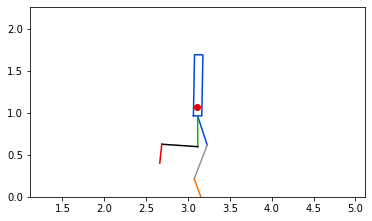

In [24]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# xmax = np.max([m.q[n,'x','b'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y','b'].value for n in range(1,N+1)]) + m.len['b']

def plot_model(i,m,ax): #update function for animation
    ax.clear()   
    ax.set_xlim([-2 + m.q[i,'x','b'].value, 2 + m.q[i,'x','b'].value]) # adjust limits to solution
    ax.set_ylim([0,ymax+0.5])
    
    #plot body
    draw_width = 0.05
    body_xtl = - (m.len[('b')])*sin(m.q[i,'th1','b'].value) - draw_width*cos(m.q[i,'th1','b'].value) + m.q[i,'x','b'].value
    body_ytl = + (m.len[('b')])*cos(m.q[i,'th1','b'].value) - draw_width*sin(m.q[i,'th1','b'].value) + m.q[i,'y','b'].value
    body_xtr = - (m.len[('b')])*sin(m.q[i,'th1','b'].value) + draw_width*cos(m.q[i,'th1','b'].value) + m.q[i,'x','b'].value
    body_ytr = + (m.len[('b')])*cos(m.q[i,'th1','b'].value) + draw_width*sin(m.q[i,'th1','b'].value) + m.q[i,'y','b'].value
    body_xbl = - draw_width*cos(m.q[i,'th1','b'].value) + m.q[i,'x','b'].value
    body_ybl = - draw_width*sin(m.q[i,'th1','b'].value) + m.q[i,'y','b'].value
    body_xbr = + draw_width*cos(m.q[i,'th1','b'].value) + m.q[i,'x','b'].value
    body_ybr = + draw_width*sin(m.q[i,'th1','b'].value) + m.q[i,'y','b'].value
    ax.plot([body_xbl,body_xtl,body_xtr,body_xbr,body_xbl],[body_ybl,body_ytl,body_ytr,body_ybr,body_ybl],color='xkcd:blue')
    
    for s in sides:
        if s == 'R':
            col = ['green','black','red']
        elif s == 'L':
            col = ['blue','grey','orange']
        #plot thighs
        leg1_xt = m.jointp[i, 'hip','x',s].value
        leg1_yt = m.jointp[i, 'hip','y',s].value
        leg1_xb = m.jointp[i,'knee','x',s].value
        leg1_yb = m.jointp[i,'knee','y',s].value
        ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:%s'%col[0])

        #plot calves
        leg2_xt = m.jointp[i, 'knee','x',s].value
        leg2_yt = m.jointp[i, 'knee','y',s].value
        leg2_xb = m.jointp[i,'ankle','x',s].value
        leg2_yb = m.jointp[i,'ankle','y',s].value
        ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:%s'%col[1])

        #plot feet
        leg3_xt = m.jointp[i,'ankle','x',s].value
        leg3_yt = m.jointp[i,'ankle','y',s].value
        leg3_xb =  m.footp[i,        'x',s].value
        leg3_yb =  m.footp[i,        'y',s].value
        ax.plot([leg3_xt,leg3_xb],[leg3_yt,leg3_yb],color='xkcd:%s'%col[2])
        
    
        
    # plot COMs
    COMx = m.massp[i,'b','x','L'].value*m.m['b']
    COMy = m.massp[i,'b','y','L'].value*m.m['b']
    Mtot = m.m['b']
    #ax.plot([m.massp[i,'b','x','L'].value],[m.massp[i,'b','y','L'].value], color='xkcd:blue',marker='o')
    for l in links:
        if l != 'b':
            for s in sides:
                COMx = COMx + m.massp[i,l,'x',s].value*m.m[l]
                COMy = COMy + m.massp[i,l,'y',s].value*m.m[l]
                Mtot = Mtot + m.m[l]
                #ax.plot([m.massp[i,l,'x',s].value],[m.massp[i,l,'y',s].value], color='xkcd:blue',marker='o')
    COMx = COMx / Mtot
    COMy = COMy / Mtot
    ax.plot([COMx],[COMy], color='xkcd:red',marker='o')
update = lambda i: plot_model(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 1000*hm,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
